In [1]:
#step 1 import image
%matplotlib inline
import torchvision.datasets
import math
import torchvision.transforms as tvt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wget
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from torchvision.utils import make_grid
from PIL import Image
from time import time
from tqdm import tqdm
import random
from transformers import ViTModel

device = torch.device('cuda:1')

def seed_everything(seed):
    """
    Changes the seed for reproducibility. 
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1024)
image_size = 64
batch_size = 1024
dataset = torchvision.datasets.CelebA("../celeba/datasets/",split='train', transform=tvt.Compose([
                                  tvt.Resize((image_size,image_size)),
                                  tvt.ToTensor(),
                                  tvt.Normalize(mean=[0.5, 0.5, 0.5],
                                                std=[0.5, 0.5, 0.5])                                  
                              ]))

test_dataset = torchvision.datasets.CelebA("../celeba/datasets/",split='test', transform=tvt.Compose([
                                  tvt.Resize((image_size,image_size)),
                                  tvt.ToTensor(),
                                  tvt.Normalize(mean=[0.5, 0.5, 0.5],
                                                std=[0.5, 0.5, 0.5])                                  
                              ]))

lengths = [int(len(dataset)*0.9), int(len(dataset)*0.1)]
if sum(lengths) != len(dataset):
    lengths[0] += len(dataset) - sum(lengths)
    
train_dataset, val_dataset = random_split(dataset, lengths)

training_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print('Done')

/home/shenyu/miniconda3/envs/DLcourse/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Done


In [2]:
from transformers import ViTConfig, ViTModel
configuration = ViTConfig(num_hidden_layers = 8, num_attention_heads = 8, 
                          intermediate_size = 768, image_size= 64, patch_size = 16)
model = ViTModel(configuration)
configuration = model.config
t = iter(test_data_loader)
img, label = next(t)
img
y = model(img)
y.last_hidden_state.shape

torch.Size([1024, 17, 768])

In [3]:
class VisionTransformer(nn.Module):
    def __init__(self, vit):
        super(VisionTransformer, self).__init__()
        self.vit = vit
        self.seq = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 1),     
            nn.Sigmoid()
        )
    
    def forward(self, x):
        z = self.vit(x)
        m = z.last_hidden_state
        g = m[:,0]
        y = self.seq(g)
        return y 

In [4]:
import random
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
import seaborn as sns

def seed_everything(seed):
    """
    Changes the seed for reproducibility. 
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train_model():
    epoch = 30
    configuration = ViTConfig(num_hidden_layers = 8, num_attention_heads = 8, 
                          intermediate_size = 768, image_size= 64, patch_size = 16)
    vit = ViTModel(configuration)
    configuration = vit.config
    vit = vit.to(device)
    model = VisionTransformer(vit)
    model = model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    
    valid_acc = []
    valid_eod = []

    for epoches in range(epoch):
        with tqdm(training_data_loader, unit="batch") as tepoch:
            for train_input, attributes in tepoch:
                # Transfer data to GPU if possible. 
                train_input = train_input.to(device)
                sensitive, train_target = attributes[:,20], attributes[:,2]
               
                train_target = train_target.float().to(device)
                train_target = train_target.unsqueeze(1)
                optimizer.zero_grad()

                # Learner update step.
                outputs = model(train_input)
                loss = criterion(outputs, train_target)
                loss.backward()
                #logger_learner.add_values(logging_dict)
                optimizer.step()
                tepoch.set_description(f"epoch %2f " % epoches)
                tepoch.set_postfix(ut_loss = loss.item())
        # Reset the dataloader if out of data.
        #model.load_state_dict(torch.load(PATH), False)
        test_pred = []
        test_gt = []
        sense_gt = []
        female_predic = []
        female_gt = []
        male_predic = []
        male_gt = []
        
        
        
        



    # Evaluate on valdi set.
        for step, (test_input, attributes) in enumerate(test_data_loader):
            sensitive, test_target = attributes[:,20], attributes[:,2]
            test_input = test_input.to(device)
            test_target = test_target.to(device)

            gt = test_target.detach().cpu().numpy()
            sen = sensitive.detach().cpu().numpy()
            test_gt.extend(gt)
            sense_gt.extend(sen)

            # Todo: split according to sensitive attribute
            # Todo: combine all batch togather

            with torch.no_grad():
                test_pred_ = model(test_input)
                test_pred.extend(torch.round(test_pred_.squeeze(1)).detach().cpu().numpy())

        for i in range(len(sense_gt)):
            if sense_gt[i] == 0:
                female_predic.append(test_pred[i])
                female_gt.append(test_gt[i])
            else:
                male_predic.append(test_pred[i])
                male_gt.append(test_gt[i])
        female_CM = confusion_matrix(female_gt, female_predic)    
        male_CM = confusion_matrix(male_gt, male_predic) 
        female_dp = (female_CM[1][1]+female_CM[0][1])/(female_CM[0][0]+female_CM[0][1]+female_CM[1][0]+female_CM[1][1])
        male_dp = (male_CM[1][1]+male_CM[0][1])/(male_CM[0][0]+male_CM[0][1]+male_CM[1][0]+male_CM[1][1])
        female_TPR = female_CM[1][1]/(female_CM[1][1]+female_CM[1][0])
        male_TPR = male_CM[1][1]/(male_CM[1][1]+male_CM[1][0])
        female_FPR = female_CM[0][1]/(female_CM[0][1]+female_CM[0][0])
        male_FPR = male_CM[0][1]/(male_CM[0][1]+male_CM[0][0])
        
        valid_acc.append(accuracy_score(test_gt, test_pred))
        valid_eod.append(0.5*(abs(female_FPR-male_FPR)+ abs(female_TPR-male_TPR)))

        print('Female TPR', female_TPR)
        print('male TPR', male_TPR)
        print('DP',abs(female_dp - male_dp))
        print('EOP', abs(female_TPR - male_TPR))
        print('EoD',0.5*(abs(female_FPR-male_FPR)+ abs(female_TPR-male_TPR)))
        print('acc', accuracy_score(test_gt, test_pred))
        print('Trade off',accuracy_score(test_gt, test_pred)*(1-0.5*(abs(female_FPR-male_FPR)+ abs(female_TPR-male_TPR))) )
        
    return valid_acc,  valid_eod


seed_everything(1024)    
va, ve = train_model()

epoch 0.000000 : 100%|██████████████████████████████████████████████| 143/143 [02:14<00:00,  1.06batch/s, ut_loss=0.482]


Female TPR 0.8585921843687375
male TPR 0.47126436781609193
DP 0.5390445560463946
EOP 0.3873278165526456
EoD 0.3838897920661666
acc 0.7663059813645927
Trade off 0.4721289375194795


epoch 1.000000 : 100%|████████████████████████████████████████████████| 143/143 [02:15<00:00,  1.06batch/s, ut_loss=0.5]


Female TPR 0.8959168336673347
male TPR 0.6368861024033438
DP 0.5040434466181383
EOP 0.2590307312639909
EoD 0.3186324999819459
acc 0.7757739705440336
Trade off 0.5285871708886678


epoch 2.000000 : 100%|██████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.449]


Female TPR 0.8879008016032064
male TPR 0.6311389759665622
DP 0.48747999232264
EOP 0.2567618256366442
EoD 0.29666434231754335
acc 0.7830878669471997
Trade off 0.5507736199224608


epoch 3.000000 : 100%|██████████████████████████████████████████████| 143/143 [02:15<00:00,  1.06batch/s, ut_loss=0.419]


Female TPR 0.8920340681362725
male TPR 0.6175548589341693
DP 0.4953233034809906
EOP 0.2744792092021032
EoD 0.3031782993580323
acc 0.7886985272016832
Trade off 0.5495822490184921


epoch 4.000000 : 100%|██████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.407]


Female TPR 0.905936873747495
male TPR 0.6280041797283177
DP 0.5055720710048901
EOP 0.2779326940191773
EoD 0.31403120737586215
acc 0.7881474802124036
Trade off 0.540644575411059


epoch 5.000000 : 100%|██████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.407]


Female TPR 0.9159569138276553
male TPR 0.6462904911180773
DP 0.508262427911638
EOP 0.26966642270957797
EoD 0.32289539804936707
acc 0.7779280633203086
Trade off 0.5267386716607243


epoch 6.000000 : 100%|██████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.372]


Female TPR 0.9157064128256514
male TPR 0.6786833855799373
DP 0.4876023707526665
EOP 0.237023027245714
EoD 0.30137443820051907
acc 0.7721170223424506
Trade off 0.539420688508937


epoch 7.000000 : 100%|██████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.351]


Female TPR 0.9019288577154309
male TPR 0.696969696969697
DP 0.45449293572285426
EOP 0.20495916074573384
EoD 0.265700910966818
acc 0.7693617873960525
Trade off 0.564941659621862


epoch 8.000000 : 100%|██████████████████████████████████████████████| 143/143 [02:22<00:00,  1.00batch/s, ut_loss=0.299]


Female TPR 0.874248496993988
male TPR 0.6206896551724138
DP 0.46427796064807964
EOP 0.2535588418215742
EoD 0.28269480883985026
acc 0.7715659753531711
Trade off 0.5534482794433738


epoch 9.000000 : 100%|██████████████████████████████████████████████| 143/143 [02:15<00:00,  1.06batch/s, ut_loss=0.273]


Female TPR 0.8498246492985972
male TPR 0.5600835945663531
DP 0.46540651351070883
EOP 0.2897410547322441
EoD 0.2931811412228495
acc 0.7683598837791804
Trade off 0.5430912561829443


epoch 10.000000 : 100%|█████████████████████████████████████████████| 143/143 [02:15<00:00,  1.06batch/s, ut_loss=0.206]


Female TPR 0.8284068136272545
male TPR 0.5977011494252874
DP 0.40723178943501503
EOP 0.23070566420196714
EoD 0.23606005726616272
acc 0.7556357078449053
Trade off 0.5772602993786795


epoch 11.000000 : 100%|█████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.178]


Female TPR 0.8369238476953907
male TPR 0.5950888192267503
DP 0.4210881964506657
EOP 0.24183502846864047
EoD 0.2523219737289765
acc 0.7544835186855025
Trade off 0.5641107481047933


epoch 12.000000 : 100%|█████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.135]


Female TPR 0.843687374749499
male TPR 0.6394984326018809
DP 0.4124225801380009
EOP 0.20418894214761807
EoD 0.23534341587342072
acc 0.7564873259192466
Trade off 0.5784530145724615


epoch 13.000000 : 100%|█████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.121]


Female TPR 0.8390531062124249
male TPR 0.5867293625914316
DP 0.44454433032418006
EOP 0.2523237436209933
EoD 0.27728702058425875
acc 0.7539324716962228
Trade off 0.5448767828978511


epoch 14.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.0804]


Female TPR 0.8384268537074149
male TPR 0.5726227795193313
DP 0.4361363511404726
EOP 0.2658040741880836
EoD 0.27360878671695416
acc 0.7514778078348863
Trade off 0.5458668765884667


epoch 15.000000 : 100%|████████████████████████████████████████████| 143/143 [02:25<00:00,  1.02s/batch, ut_loss=0.0702]


Female TPR 0.813376753507014
male TPR 0.5752351097178683
DP 0.4185874557293675
EOP 0.2381416437891457
EoD 0.24635909104729037
acc 0.7583909427913035
Trade off 0.5715544394667403


epoch 16.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.06batch/s, ut_loss=0.0701]


Female TPR 0.8309118236472945
male TPR 0.6191222570532915
DP 0.4140448907534645
EOP 0.21178956659400305
EoD 0.24107646773807134
acc 0.753030758441038
Trade off 0.5714927630979517


epoch 17.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.0509]


Female TPR 0.8312875751503006
male TPR 0.5893416927899686
DP 0.42701355407524777
EOP 0.241945882360332
EoD 0.25541915259841297
acc 0.757940086163711
Trade off 0.5643476716354078


epoch 18.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.0491]


Female TPR 0.8340430861723447
male TPR 0.5841170323928945
DP 0.4269975093031367
EOP 0.2499260537794502
EoD 0.2607436681382532
acc 0.7529305680793508
Trade off 0.5566086899049221


epoch 19.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.0464]


Female TPR 0.8097444889779559
male TPR 0.5626959247648903
DP 0.41948451301126766
EOP 0.24704856421306565
EoD 0.2517339548384257
acc 0.7547339945897205
Trade off 0.5647418212806472


epoch 20.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.0591]


Female TPR 0.8599699398797596
male TPR 0.6233019853709509
DP 0.4389973901315444
EOP 0.23666795450880862
EoD 0.2707363977807172
acc 0.7515279030157299
Trade off 0.5480619457215551


epoch 21.000000 : 100%|████████████████████████████████████████████| 143/143 [02:16<00:00,  1.05batch/s, ut_loss=0.0341]


Female TPR 0.8543336673346693
male TPR 0.6269592476489029
DP 0.43146369227354786
EOP 0.22737441968576644
EoD 0.25744952071626637
acc 0.7571385632702134
Trade off 0.5622136030404945


epoch 22.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.0647]


Female TPR 0.8444388777555111
male TPR 0.5684430512016719
DP 0.45379225756135017
EOP 0.27599582655383914
EoD 0.29004717492678517
acc 0.7546338042280333
Trade off 0.5357544012074396


epoch 23.000000 : 100%|████████████████████████████████████████████| 143/143 [02:16<00:00,  1.05batch/s, ut_loss=0.0264]


Female TPR 0.8371743486973948
male TPR 0.5982236154649948
DP 0.42500126871177896
EOP 0.23895073323240001
EoD 0.25458337435573125
acc 0.7557358982065925
Trade off 0.5633381031193987


epoch 24.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.0356]


Female TPR 0.8476953907815631
male TPR 0.622257053291536
DP 0.42744619140661694
EOP 0.22543833749002706
EoD 0.25295134659555685
acc 0.7575393247169623
Trade off 0.5659187324307179


epoch 25.000000 : 100%|████████████████████████████████████████████| 143/143 [02:16<00:00,  1.05batch/s, ut_loss=0.0438]


Female TPR 0.8484468937875751
male TPR 0.6154649947753396
DP 0.4312655774390184
EOP 0.23298189901223554
EoD 0.26178510495012847
acc 0.7526800921751328
Trade off 0.5556396552511932


epoch 26.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.0188]


Female TPR 0.8405561122244489
male TPR 0.5694879832810867
DP 0.44768771920336436
EOP 0.2710681289433622
EoD 0.28292289059519116
acc 0.7550846608556256
Trade off 0.5414539259622625


epoch 27.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.0253]


Female TPR 0.8525801603206413
male TPR 0.6050156739811913
DP 0.43857838450629594
EOP 0.24756448633945005
EoD 0.27048656744620225
acc 0.75403266205791
Trade off 0.5500769555555437


epoch 28.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.0315]


Female TPR 0.8351703406813628
male TPR 0.5606060606060606
DP 0.4473086561704293
EOP 0.2745642800753022
EoD 0.2810049639192382
acc 0.7579901813445546
Trade off 0.5449911777846912


epoch 29.000000 : 100%|████████████████████████████████████████████| 143/143 [02:15<00:00,  1.05batch/s, ut_loss=0.0179]


Female TPR 0.810370741482966
male TPR 0.5663531870428422
DP 0.41320976883198235
EOP 0.24401755444012374
EoD 0.24562188508974858
acc 0.7540827572387536
Trade off 0.5688635288920957


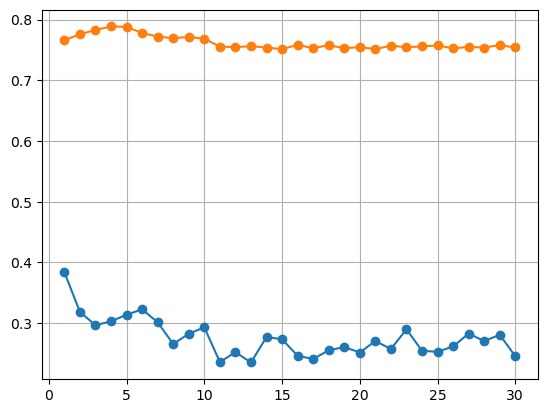

In [10]:
import matplotlib.pyplot as plt

# Sample data

# Create a basic plot
x = list(range(1, 31)) 
plt.plot(x, ve, marker='o')  # 'o' specifies marker style
plt.plot(x, va, marker='o')  # 'o' specifies marker style
#plt.xlabel('X-axis')
#plt.ylabel('Y-axis')
plt.grid(True)
plt.show()
